In [1]:
import numpy as np 
import torch as th

$$\sum_{n=1}^{N-1} \|p(n) - p(n-1)\|^2 = \sum_{n=1}^{N-1} (p(n) - p(n-1))^\top G_{p(n) - p(n-1)}(p(n) - p(n-1))$$

In [2]:
def min_energy_points(start_p, end_p, metric, N, epochs=10):
    d = len(start_p)
    points = th.randn((N, d), requires_grad=True)
    optimizer = th.optim.LBFGS([points], lr=1e-2)
    
    for i in range(epochs): 
        optimizer.zero_grad()
        
        differences = points[1:] - points[:-1]
        dif_start = points[0] - start_p 
        dif_end = end_p - points[-1]
        
        G = metric(differences)
        G_start = metric(dif_start)
        G_end = metric(dif_end)
        
        loss = 0
        for i, iden in enumerate(G): 
            loss += differences[i].T @ iden @ differences[i] 
        loss += dif_start.T @ G_start.squeeze() @ dif_start + dif_end.T @ G_end.squeeze() @ dif_end
        
        loss.backward()
        optimizer.step()
        print(loss)
    
    return points, loss

def min_energy_poly(start_p, end_p, metric, N, epochs=10, degree=3):
    d = len(start_p)
    points = th.randn((N, d), requires_grad=True)
    optimizer = th.optim.LBFGS([points], lr=1e-2)
    
    for i in range(epochs): 
        optimizer.zero_grad()
        
        differences = points[1:] - points[:-1]
        dif_start = points[0] - start_p 
        dif_end = end_p - points[-1]
        
        G = metric(differences)
        G_start = metric(dif_start)
        G_end = metric(dif_end)
        
        loss = 0
        for i, iden in enumerate(G): 
            loss += differences[i].T @ iden @ differences[i] 
        loss += dif_start.T @ G_start.squeeze() @ dif_start + dif_end.T @ G_end.squeeze() @ dif_end
        
        loss.backward()
        optimizer.step()
    
    # Now I have assumed the dimension to be 2, but otherwise I cannot just fit polynomials 
    x = th.cat((start_p[0], points[:, 0], end_p[0]))
    y = th.cat((start_p[1], points[:, 1], end_p[1]))
    powers = [x]
    for i in range(1, degree + 1): 
        powers.append(x**i)
    
    polynomials = []
    definition_times = [] 
    
    for i in range(len(points) - degree): 
        defstart = 1 
        defend = 2 
        
        if i == 0: 
            defstart = 0 
        elif i == len(points) - degree: 
            defend = 3
        
        ys = y[i:degree+1]  
        factors = th.linalg.inv(th.stack([row[i:degree+1] for row in powers])) @ ys    
        polynomials.append(lambda x: sum([x**i *factors[i] for i in range(len(factors))]))
        definition_times.append((powers[0][i+defstart], powers[0][i+defend]))
    
    return polynomials, definition_times
        

In [27]:

def min_energy_points(start_p, end_p, metric, N, epochs=10):
    d = len(start_p)
    points = th.randn((N, d), requires_grad=True)
    optimizer = th.optim.LBFGS([points], lr=1e-2)

    def closure():
        optimizer.zero_grad()
        
        differences = points[1:] - points[:-1]
        dif_start = points[0] - start_p
        dif_end = end_p - points[-1]
        
        G = metric(points[:-1] + differences/2)
        G_start = metric(start_p + dif_start/2)
        G_end = metric(points[-1] + dif_end/2)
        
        loss = 0
        for i, iden in enumerate(G): 
            loss += differences[i].T @ iden @ differences[i] 
        loss += dif_start.T @ G_start.squeeze() @ dif_start + dif_end.T @ G_end.squeeze() @ dif_end
        
        loss.backward()
        return loss  # LBFGS needs the loss value to be returned

    for i in range(epochs): 
        loss = optimizer.step(closure)  # Pass the closure to LBFGS
        print(loss)
    

    return points, loss


def min_energy_poly(start_p, end_p, metric, N, epochs=10, degree=3):
    d = len(start_p)
    points = th.randn((N, d), requires_grad=True)
    optimizer = th.optim.LBFGS([points], lr=1e-2)

    def closure():
        optimizer.zero_grad()
        
        differences = points[1:] - points[:-1]
        dif_start = points[0] - start_p
        dif_end = end_p - points[-1]
        
        G = metric(points[:-1] + differences/2)
        G_start = metric(start_p + dif_start/2)
        G_end = metric(points[-1] + dif_end/2)
        
        loss = 0
        for i, iden in enumerate(G): 
            loss += differences[i].T @ iden @ differences[i] 
        loss += dif_start.T @ G_start.squeeze() @ dif_start + dif_end.T @ G_end.squeeze() @ dif_end
        
        loss.backward()
        return loss  # LBFGS needs the loss value to be returned

    for i in range(epochs): 
        loss = optimizer.step(closure)  # Pass the closure to LBFGS
        print(loss)
    
    # Now I have assumed the dimension to be 2, but otherwise I cannot just fit polynomials 
    x = th.cat((start_p[0].unsqueeze(-1), points[:, 0], end_p[0].unsqueeze(-1)))
    y = th.cat((start_p[1].unsqueeze(-1), points[:, 1], end_p[1].unsqueeze(-1)))
    powers = [x]
    for i in range(1, degree + 1): 
        powers.append(x**i)
    
    polynomials = []
    definition_times = [] 
    
    for i in range(len(points) - degree): 
        defstart = 1 
        defend = 2 
        
        if i == 0: 
            defstart = 0 
        elif i == len(points) - degree: 
            defend = 3
        
        ys = y[i:i+degree+1]  
        matrix = th.eye(degree + 1) * 1e-10 + th.stack([row[i:i + degree+1] for row in powers])
        print(matrix)
        factors = th.linalg.inv(matrix) @ ys    
        polynomials.append(lambda x: sum([x**i *factors[i] for i in range(len(factors))]))
        definition_times.append((powers[0][i+defstart], powers[0][i+defend]))
    
    return points, polynomials, definition_times

In [8]:
start_p = th.Tensor([10,0])
end_p = th.Tensor([0,10])
def metric(points): 
    if len(points.shape) < 2: 
        points = points.unsqueeze(0) 
    iden = th.eye(points.shape[1]) 
    norms = th.norm(points, dim=1)**2 + 1
    return norms[:, None, None]*iden[None, :, :]    
N=10

In [28]:
points, polynomials, deftimes = min_energy_poly(start_p=start_p, end_p=end_p, metric=metric, N=N, epochs=100)

tensor(5102.5840, grad_fn=<AddBackward0>)
tensor(3396.0220, grad_fn=<AddBackward0>)
tensor(2840.8560, grad_fn=<AddBackward0>)
tensor(2524.6987, grad_fn=<AddBackward0>)
tensor(2369.7466, grad_fn=<AddBackward0>)
tensor(2095.8425, grad_fn=<AddBackward0>)
tensor(1927.2798, grad_fn=<AddBackward0>)
tensor(1822.4293, grad_fn=<AddBackward0>)
tensor(1649.2295, grad_fn=<AddBackward0>)
tensor(1544.2915, grad_fn=<AddBackward0>)
tensor(1471.8551, grad_fn=<AddBackward0>)
tensor(1402.7988, grad_fn=<AddBackward0>)
tensor(1368.3370, grad_fn=<AddBackward0>)
tensor(1345.0615, grad_fn=<AddBackward0>)
tensor(1329.2688, grad_fn=<AddBackward0>)
tensor(1319.2102, grad_fn=<AddBackward0>)
tensor(1312.7302, grad_fn=<AddBackward0>)
tensor(1308.5109, grad_fn=<AddBackward0>)
tensor(1305.7239, grad_fn=<AddBackward0>)
tensor(1303.8689, grad_fn=<AddBackward0>)
tensor(1302.6418, grad_fn=<AddBackward0>)
tensor(1301.8203, grad_fn=<AddBackward0>)
tensor(1301.2732, grad_fn=<AddBackward0>)
tensor(1300.9077, grad_fn=<AddBack

_LinAlgError: linalg.inv: The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.

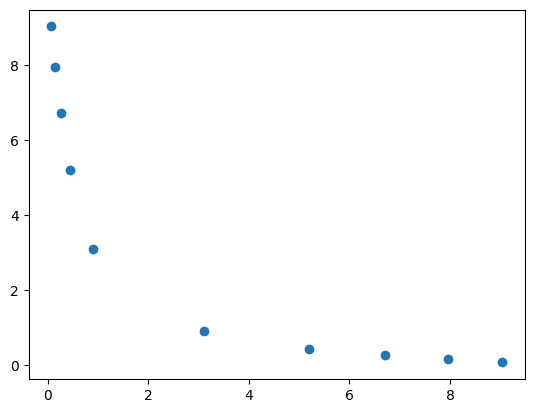

In [64]:
import matplotlib.pyplot as plt 
points = points.detach()
plt.plot(points[:, 0], points[:, 1],'o')
plt.show()